In [1]:
from pathlib import Path
from functools import partial

# Data & Visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

# TorchVision & Transforms
import torchvision
import torchvision.transforms.v2 as T

# Metrics & Summary
import torchmetrics
from torchmetrics.classification import Accuracy
from torchinfo import summary

In [2]:
# Device Configuration
if torch.cuda.is_available():
    device = "cuda"  # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps"   # Apple Silicon GPU (M1/M2)
else:
    device = "cpu"   # Default to CPU

print(f"Using device: {device}")

Using device: mps


## Part One: LeNet-5 Model

In [3]:
# Load, preprocess, and split CIFAR-10 Dataset

# Define transformation: convert image to float32 tensor and scale pixel values to [0, 1]
transform = T.Compose([
    T.ToImage(),  
    T.ToDtype(torch.float32, scale=True)  # Scales pixel values to [0, 1]
])

# Load CIFAR-10 dataset 
train_val_data = torchvision.datasets.CIFAR10(
    root="datasets", train=True, download=True, transform=transform
)
test_data = torchvision.datasets.CIFAR10(
    root="datasets", train=False, download=True, transform=transform
)

# Split into 80% train and 20% validation
train_size = int(0.8 * len(train_val_data))
valid_size = len(train_val_data) - train_size
train_data, valid_data = random_split(
    train_val_data, [train_size, valid_size], generator=torch.Generator().manual_seed(42)
)

print(f"Train samples: {len(train_data)} | Validation samples: {len(valid_data)} | Test samples: {len(test_data)}")


100%|██████████| 170M/170M [05:38<00:00, 504kB/s]  


Train samples: 40000 | Validation samples: 10000 | Test samples: 10000


In [4]:
# Define the data loaders with a batch size of 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [5]:
# Define my model architecture (LeNet-5).

# This implementation strictly follows the original vanilla LeNet-5 structure - I have not added any modern enhancements e.g. Dropout, BatchNorm, etc.
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        
        # Extracting features (convoultion and pooling layers) 
        # First convoultional layer - input: 32x32x3 -> output: 28x28x6 (no padding, kernel = 5)
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)

        # First pooling layer - 2x2 average pooling -> output: 14x14x6
        self.pool1 = nn.AvgPool2d(2)

        # Second convolutional layer - input 14x14x6 -> output: 10x10x16
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        # Second pooling layer - 2x2 average pooling -> output: 5x5x16
        self.pool2 = nn.AvgPool2d(2)
        
        # Classifier (fully-connected layers)
        # Flattened size: 16 channels * 5 * 5 spatial dims = 400
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # First FC layer with 120 units
        self.fc2 = nn.Linear(120, 84) # Second FC layer with 84 units
        self.fc3 = nn.Linear(84, num_classes) # Output layer with 10 classes (no activation function here, logits output)

    # Define my forward pass (I am using ReLu as instructed, however, I understand typically LeNet-5 architecture uses tanh). 
    def forward(self, x):
       # Apply convolutions with ReLU and average pooling after each
       x = F.relu(self.conv1(x))
       x = self.pool1(x)
       x = F.relu(self.conv2(x))
       x = self.pool2(x)

       # Flatten the tensor for the FC layers 
       # Original image size is 32x32 -> after conv/pool layers: 5x5 feature maps with 16 channels.
       x = x.view(-1, 16 * 5 * 5)   

       # Pass through FC layers with ReLU activation
       x = F.relu(self.fc1(x))      
       x = F.relu(self.fc2(x))   

       # Output layer outputs logits for each of the 10 classes
       x = self.fc3(x)             
       return x

In [6]:
# Training function returning train and valid losses and evaluation metrics
def train(model, optimizer, loss_fn, eval_metric, train_loader, valid_loader, n_epochs):
    train_losses = []
    train_eval_metrics = []
    valid_losses = []
    valid_eval_metrics= []

    for epoch in range(n_epochs):

        # --- Training ---- 
        eval_metric.reset() # Reset the eval metric
        model.train()
        epoch_train_loss = 0.
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

            # Forward pass
            y_train_pred = model(X_train_batch)
            train_loss = loss_fn(y_train_pred, y_train_batch)

            
            # Backpropagation and optimisation
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Accumulate loss and update accuracy metric
            epoch_train_loss += train_loss.item()
            eval_metric.update(y_train_pred, y_train_batch) # Update eval metric for training

            
        # Calculate and store training eval metric for this epoch
        mean_epoch_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(mean_epoch_train_loss)
        epoch_training_eval_metric = eval_metric.compute().item()
        train_eval_metrics.append(epoch_training_eval_metric)

        # --- Validation ---
        model.eval()
        eval_metric.reset() # Reset the eval metric
        epoch_valid_loss = 0.
        with torch.no_grad():
            for X_valid_batch, y_valid_batch in valid_loader:
                X_valid_batch, y_valid_batch = X_valid_batch.to(device), y_valid_batch.to(device)
                y_valid_pred = model(X_valid_batch)
                valid_loss = loss_fn(y_valid_pred, y_valid_batch)
                epoch_valid_loss += valid_loss.item()  # Update eval metric for validation
                eval_metric.update(y_valid_pred, y_valid_batch)
        mean_epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        valid_losses.append(mean_epoch_valid_loss)
        
        # Calculate and store validation eval metric for this epoch
        epoch_valid_eval_metric = eval_metric.compute().item()
        valid_eval_metrics.append(epoch_valid_eval_metric)

        print(f"Epoch {epoch + 1}/{n_epochs}, Training Loss: {mean_epoch_train_loss:.4f}, Valid Loss: {mean_epoch_valid_loss:.4f}")
        print(f"Epoch {epoch + 1}/{n_epochs}, Training Eval Metric: {epoch_training_eval_metric:.4f}, Valid Eval Metric: {epoch_valid_eval_metric:.4f}")

    return (train_losses, valid_losses, train_eval_metrics, valid_eval_metrics)

In [7]:
# Function to evaluate the model on the test set (evaluation metric only)
def evaluate_test_set(model, eval_metric, test_loader, metric_print):
    model.eval()
    eval_metric.reset()
    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            y_test_logits = model(X_test_batch)

            # Pass logits to eval_metric to apply argmax interally
            eval_metric.update(y_test_logits, y_test_batch)
            
    total_test_eval_metric = eval_metric.compute().item()
    if metric_print:
        print(f"Test Accuracy: {total_test_eval_metric * 100:.2f}%")
    return total_test_eval_metric

In [8]:
# Insantiate model and set hyperparameters (loss, metric, and optimiser)
model = LeNet5().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
n_epochs = 20

# Display a summary of my model
summary(model, input_size=(3, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [1, 10]                   --
├─Conv2d: 1-1                            [6, 28, 28]               456
├─AvgPool2d: 1-2                         [6, 14, 14]               --
├─Conv2d: 1-3                            [16, 10, 10]              2,416
├─AvgPool2d: 1-4                         [16, 5, 5]                --
├─Linear: 1-5                            [1, 120]                  48,120
├─Linear: 1-6                            [1, 84]                   10,164
├─Linear: 1-7                            [1, 10]                   850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.52
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31

In [9]:
# Train model and track loss and accuracy for each epoch
lenet_train_losses, lenet_valid_losses, lenet_train_accuracy, lenet_valid_accuracy = train(model, optimizer, xentropy, accuracy, train_loader, valid_loader, n_epochs)

Epoch 1/20, Training Loss: 1.7785, Valid Loss: 1.6016
Epoch 1/20, Training Eval Metric: 0.3455, Valid Eval Metric: 0.4159
Epoch 2/20, Training Loss: 1.5184, Valid Loss: 1.4511
Epoch 2/20, Training Eval Metric: 0.4524, Valid Eval Metric: 0.4800
Epoch 3/20, Training Loss: 1.4230, Valid Loss: 1.3936
Epoch 3/20, Training Eval Metric: 0.4861, Valid Eval Metric: 0.4995
Epoch 4/20, Training Loss: 1.3479, Valid Loss: 1.3462
Epoch 4/20, Training Eval Metric: 0.5153, Valid Eval Metric: 0.5161
Epoch 5/20, Training Loss: 1.2813, Valid Loss: 1.2984
Epoch 5/20, Training Eval Metric: 0.5397, Valid Eval Metric: 0.5386
Epoch 6/20, Training Loss: 1.2380, Valid Loss: 1.2747
Epoch 6/20, Training Eval Metric: 0.5565, Valid Eval Metric: 0.5476
Epoch 7/20, Training Loss: 1.1913, Valid Loss: 1.2523
Epoch 7/20, Training Eval Metric: 0.5729, Valid Eval Metric: 0.5520
Epoch 8/20, Training Loss: 1.1531, Valid Loss: 1.2303
Epoch 8/20, Training Eval Metric: 0.5906, Valid Eval Metric: 0.5632
Epoch 9/20, Training Los

## Evaluation of LeNet-5 Model

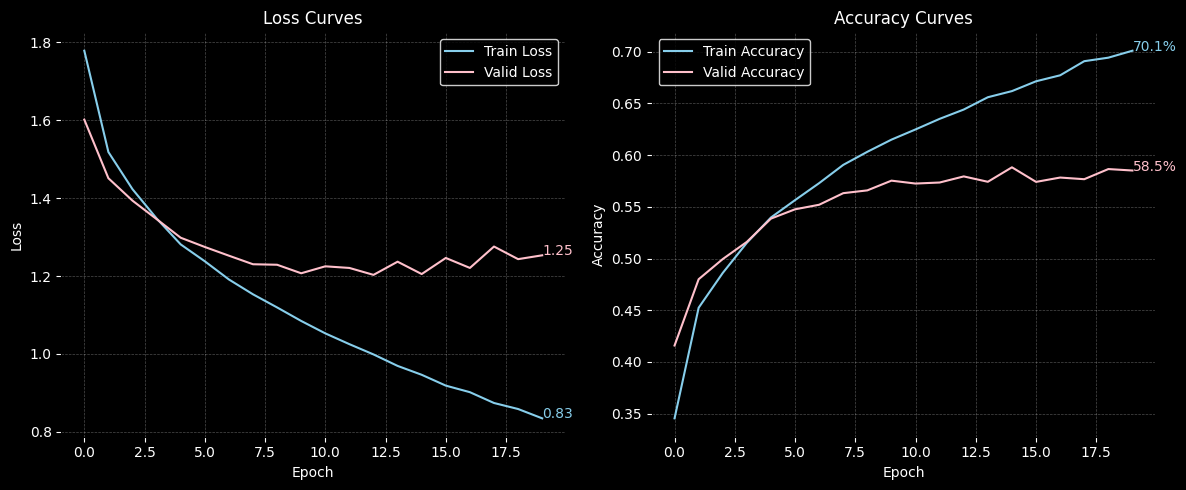

In [10]:
# Plot training and validation loss and accuracy curves for visual performance tracking

# Create side by side subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.patch.set_facecolor("black")

# Loss curve to plot training and validation loss per epoch
ax1.plot(lenet_train_losses, label="Train Loss", color="skyblue")
ax1.plot(lenet_valid_losses, label="Valid Loss", color="pink")
ax1.set_title("Loss Curves", color="white")
ax1.set_xlabel("Epoch", color="white")
ax1.set_ylabel("Loss", color="white")
ax1.set_facecolor("black")
ax1.tick_params(colors="white")
ax1.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
ax1.annotate(f"{lenet_train_losses[-1]:.2f}", xy=(len(lenet_train_losses)-1, lenet_train_losses[-1]), color='skyblue')
ax1.annotate(f"{lenet_valid_losses[-1]:.2f}", xy=(len(lenet_valid_losses)-1, lenet_valid_losses[-1]), color='pink')
legend1 = ax1.legend(facecolor='black', edgecolor='white')
for text in legend1.get_texts():
    text.set_color('white')

# Accuracy curve to plot training and validation accuracy per epoch
ax2.plot(lenet_train_accuracy, label="Train Accuracy", color="skyblue")
ax2.plot(lenet_valid_accuracy, label="Valid Accuracy", color="pink")
ax2.set_title("Accuracy Curves", color="white")
ax2.set_xlabel("Epoch", color="white")
ax2.set_ylabel("Accuracy", color="white")
ax2.set_facecolor("black")
ax2.tick_params(colors="white")
ax2.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
ax2.annotate(f"{lenet_train_accuracy[-1]*100:.1f}%", xy=(len(lenet_train_accuracy)-1, lenet_train_accuracy[-1]), color='skyblue')
ax2.annotate(f"{lenet_valid_accuracy[-1]*100:.1f}%", xy=(len(lenet_valid_accuracy)-1, lenet_valid_accuracy[-1]), color='pink')
legend2 = ax2.legend(facecolor='black', edgecolor='white')
for text in legend2.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.show()

In [11]:
# Compute and display the accuracy of the model on the test set. 
lenet_test_acc = evaluate_test_set(model, accuracy, test_loader, metric_print=True)

Test Accuracy: 58.19%


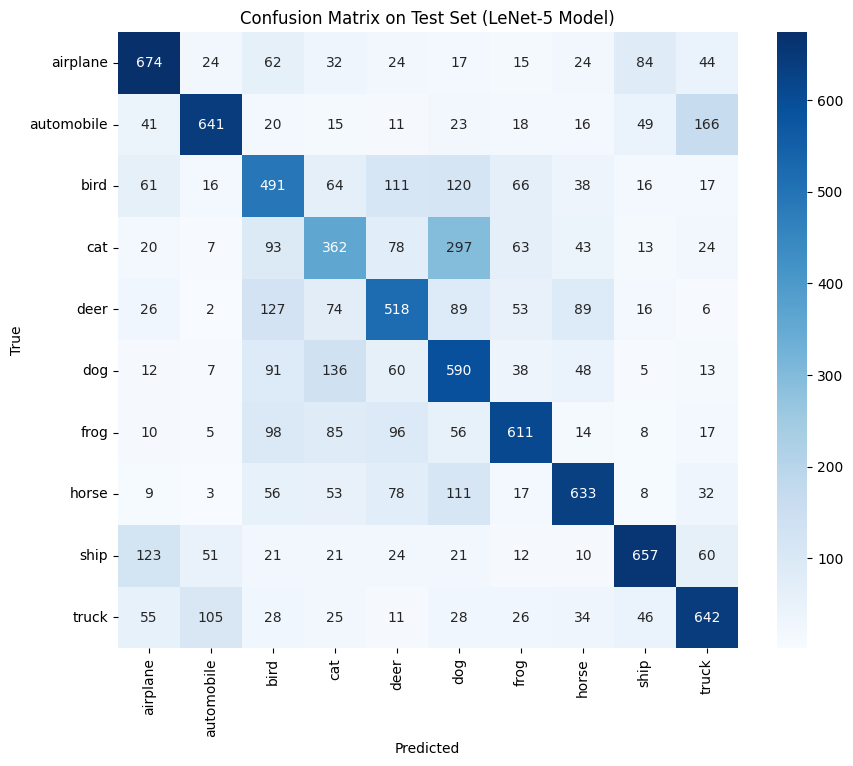

In [12]:
# Create and display a confusion matrix to evaluate model performance on the test set

model.eval()

# Store predictions and true labels
lenet_all_preds = []
lenet_all_labels = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch = X_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)

        y_pred_logits = model(X_test_batch)
        y_pred_classes = torch.argmax(y_pred_logits, dim=1)

        lenet_all_preds.extend(y_pred_classes.cpu().numpy())
        lenet_all_labels.extend(y_test_batch.cpu().numpy())

# Get the confusion matrix
lenet_cm = confusion_matrix(lenet_all_labels, lenet_all_preds)
labels = test_data.classes  

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(lenet_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Set (LeNet-5 Model)")
plt.show()

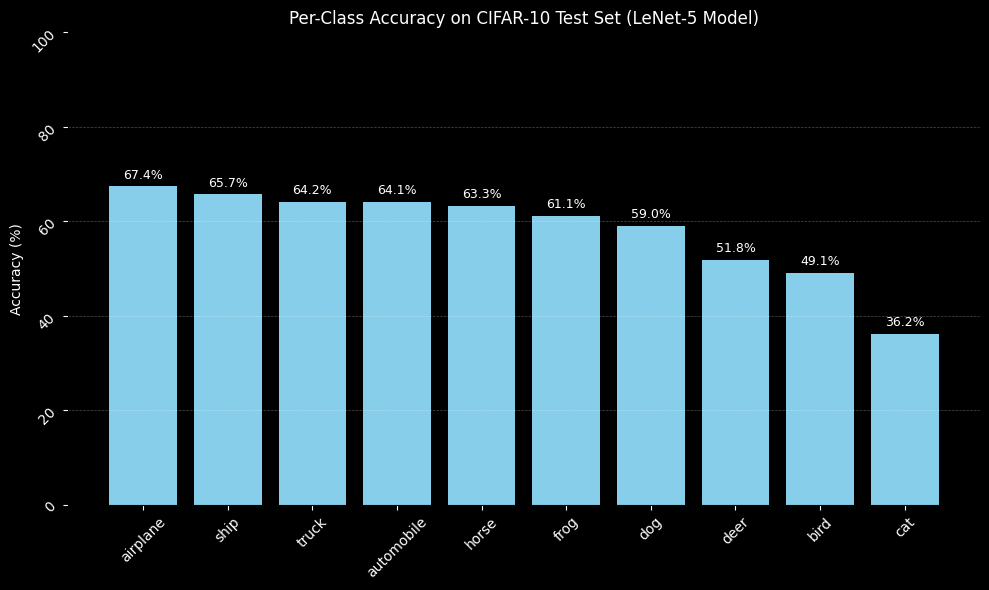

In [13]:
# Display per-class accuracy as a bar chart on the test set
lenet_all_labels = np.array(lenet_all_labels)
lenet_all_preds = np.array(lenet_all_preds)


class_names = test_data.classes

# Compute per-class accuracy
per_class_acc = []
for i, class_name in enumerate(class_names):
    class_mask = (lenet_all_labels == i)
    correct = (lenet_all_preds[class_mask] == i).sum()
    total = class_mask.sum()  
    acc = correct / total
    per_class_acc.append(acc)


sorted_indices = np.argsort(per_class_acc)[::-1]
sorted_names = [class_names[i] for i in sorted_indices]
sorted_acc = [per_class_acc[i] for i in sorted_indices]

#  Plot bar chart 
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

bars = ax.bar(sorted_names, [a * 100 for a in sorted_acc], color="skyblue")

ax.set_ylabel("Accuracy (%)", color="white")
ax.set_title("Per-Class Accuracy on CIFAR-10 Test Set (LeNet-5 Model)", color="white")
ax.set_ylim(0, 100)
ax.tick_params(colors="white", rotation=45)


ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3, axis='y')

for bar, acc in zip(bars, sorted_acc):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
            f"{acc * 100:.1f}%", ha="center", va="bottom", fontsize=9, color="white")

plt.tight_layout()
plt.show()

---
### LeNet-5 Performance
My LeNet-5 model achieved a test accuracy of ~57% on CIFAR-10. While training loss and accuracy improved steadily, validation loss plateaued and remained higher. Validation accuracy stagnated earlier indicating overfitting. This suggests the model is learning the training data well but struggles to generalise to unseen data. Given CIFAR-10’s complexity, the shallow LeNet-5 architecture lacks sufficient depth and regularisation to capture high-level features effectively. Despite performing reasonably for its simplicity, performance could be improved by incorporating modern techniques such as batch normalisation, dropout, and deeper convolutional layers to enhance feature learning and improve generalisation.

---

## Part Two: Improve Accuracy of LeNet-5 Model

In [14]:

# Build on my previous train function by adding a learning rate scheduler to reduce learning rate when validation loss plateaus to improve convergence and generalisation

# Training function returning train and valid losses and evaluation metrics
def train_v2(model, optimizer, loss_fn, eval_metric, train_loader, valid_loader, n_epochs):
    train_losses = []
    train_eval_metrics = []
    valid_losses = []
    valid_eval_metrics= []

    for epoch in range(n_epochs):

        # --- Training ---- 
        eval_metric.reset() # Reset the eval metric
        model.train()
        epoch_train_loss = 0.
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

            # Forward pass
            y_train_pred = model(X_train_batch)
            train_loss = loss_fn(y_train_pred, y_train_batch)

            
            # Backpropagation and optimisation
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Accumulate loss and update accuracy metric
            epoch_train_loss += train_loss.item()
            eval_metric.update(y_train_pred, y_train_batch) # Update eval metric for training

            
        # Calculate and store training eval metric for this epoch
        mean_epoch_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(mean_epoch_train_loss)
        epoch_training_eval_metric = eval_metric.compute().item()
        train_eval_metrics.append(epoch_training_eval_metric)

        # --- Validation ---
        model.eval()
        eval_metric.reset() # Reset the eval metric
        epoch_valid_loss = 0.
        with torch.no_grad():
            for X_valid_batch, y_valid_batch in valid_loader:
                X_valid_batch, y_valid_batch = X_valid_batch.to(device), y_valid_batch.to(device)
                y_valid_pred = model(X_valid_batch)
                valid_loss = loss_fn(y_valid_pred, y_valid_batch)
                epoch_valid_loss += valid_loss.item()  # Update eval metric for validation
                eval_metric.update(y_valid_pred, y_valid_batch)
        mean_epoch_valid_loss = epoch_valid_loss / len(valid_loader)

        # Add a learning rate scheduler 
        lr_scheduler.step(mean_epoch_valid_loss)
    
        valid_losses.append(mean_epoch_valid_loss)
        
        # Calculate and store validation eval metric for this epoch
        epoch_valid_eval_metric = eval_metric.compute().item()
        valid_eval_metrics.append(epoch_valid_eval_metric)

        print(f"Epoch {epoch + 1}/{n_epochs}, Training Loss: {mean_epoch_train_loss:.4f}, Valid Loss: {mean_epoch_valid_loss:.4f}")
        print(f"Epoch {epoch + 1}/{n_epochs}, Training Eval Metric: {epoch_training_eval_metric:.4f}, Valid Eval Metric: {epoch_valid_eval_metric:.4f}")

    return (train_losses, valid_losses, train_eval_metrics, valid_eval_metrics)

In [15]:
# Load the full training data (without transformations for now)
full_train_data = torchvision.datasets.CIFAR10(root="datasets", train=True, download=True)

# Split dataset into 80% for training and 20% for validation with a fixed random seed for reproducibility
train_size = int(0.8 * len(full_train_data))
valid_size = len(full_train_data) - train_size
train_indices, valid_indices = random_split(full_train_data, [train_size, valid_size], generator=torch.Generator().manual_seed(42))

# I add data augmentation by applying to training set only to improve generalisation
train_transforms = T.Compose([
    T.RandomHorizontalFlip(),        # Randomly flip images
    T.RandomCrop(32, padding=4),     # Random crop with padding
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Randomly adjust brightness, contrast, saturation, and hue
    T.RandomRotation(15),            # Randomly rotate the image by up to +-15 degrees
    T.ToTensor()                     # Convert to tensor and scale pixel values to [0, 1]
])

# Basic transform for validation and test sets (no augmentation)
test_valid_transforms = T.Compose([
    T.ToTensor() 
])

# Reload datasets with transforms applied
train_data = torchvision.datasets.CIFAR10(root="datasets", train=True, transform=train_transforms)
valid_data = torchvision.datasets.CIFAR10(root="datasets", train=True, transform=test_valid_transforms)

# Create subsets using the same indices from earlier to correctly apply different transformations
train_subset = torch.utils.data.Subset(train_data, train_indices.indices)
valid_subset = torch.utils.data.Subset(valid_data, valid_indices.indices)

# Load test data (no augmentation)
test_data = torchvision.datasets.CIFAR10(root="datasets", train=False, download=True, transform=test_valid_transforms)

/opt/anaconda3/envs/CompSci714/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [16]:
# Define the data loaders with a batch size of 32
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [17]:
# Improved CNN model based on LeNet-5 with added depth, batch normalisation, dropout, and max pooling
class ImprovedModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedModel, self).__init__()

        # First convolutional block: Conv -> BN -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)  # Output: 32x16x16

        # Second conv block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)  # Output: 64x8x8

        # Third conv block (no pooling)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fourth conv block + pooling to reduce size further
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2)  # Output: 256x4x4

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 120)
        self.dropout1 = nn.Dropout(p=0.3)  # Dropout to reduce overfitting
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)  # Output layer (no activation, raw logits)

    def forward(self, x):
        # Apply 4 convolutional blocks with batch norm and ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool3(x)

        # Flatten before fully connected layers
        x = x.view(-1, 256 * 4 * 4)

        # Classifier with dropout
        x = F.relu(self.dropout1(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [18]:
# Insantiate model and set hyperparameters
model = ImprovedModel().to(device)

# Add weight decay to optimiser to regularise the model to help reduce overfitting
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Add a learning rate scheduler to reduce learning rate when validation loss plateaus to improve convergence and generalisation
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, min_lr=1e-5)

# Add label smoothing to penalise overconfident predictions to help with generalisation
xentropy = nn.CrossEntropyLoss(label_smoothing=0.1)

accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

# Increase epochs from 20 to 60, as my model needs more time to learn due to added methods for 
# better generalisation and a deeper model to learn more complex patterns.
n_epochs = 60

# Display a summary of my model
summary(model, input_size=(32, 3, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedModel                            [32, 10]                  --
├─Conv2d: 1-1                            [32, 32, 32, 32]          896
├─BatchNorm2d: 1-2                       [32, 32, 32, 32]          64
├─MaxPool2d: 1-3                         [32, 32, 16, 16]          --
├─Conv2d: 1-4                            [32, 64, 16, 16]          18,496
├─BatchNorm2d: 1-5                       [32, 64, 16, 16]          128
├─MaxPool2d: 1-6                         [32, 64, 8, 8]            --
├─Conv2d: 1-7                            [32, 128, 8, 8]           73,856
├─BatchNorm2d: 1-8                       [32, 128, 8, 8]           256
├─Conv2d: 1-9                            [32, 256, 8, 8]           295,168
├─BatchNorm2d: 1-10                      [32, 256, 8, 8]           512
├─MaxPool2d: 1-11                        [32, 256, 4, 4]           --
├─Linear: 1-12                           [32, 120]                 4

In [19]:
# Train model
improved_train_losses, improved_valid_losses, improved_train_accuracy, improved_valid_accuracy = train_v2(model, optimizer, xentropy, accuracy, train_loader, valid_loader, n_epochs)

Epoch 1/60, Training Loss: 1.8582, Valid Loss: 1.8186
Epoch 1/60, Training Eval Metric: 0.3489, Valid Eval Metric: 0.4129
Epoch 2/60, Training Loss: 1.6287, Valid Loss: 1.5166
Epoch 2/60, Training Eval Metric: 0.4760, Valid Eval Metric: 0.5456
Epoch 3/60, Training Loss: 1.5254, Valid Loss: 1.3557
Epoch 3/60, Training Eval Metric: 0.5319, Valid Eval Metric: 0.6201
Epoch 4/60, Training Loss: 1.4417, Valid Loss: 1.3337
Epoch 4/60, Training Eval Metric: 0.5751, Valid Eval Metric: 0.6268
Epoch 5/60, Training Loss: 1.3794, Valid Loss: 1.2717
Epoch 5/60, Training Eval Metric: 0.6036, Valid Eval Metric: 0.6514
Epoch 6/60, Training Loss: 1.3267, Valid Loss: 1.2821
Epoch 6/60, Training Eval Metric: 0.6311, Valid Eval Metric: 0.6605
Epoch 7/60, Training Loss: 1.2906, Valid Loss: 1.2036
Epoch 7/60, Training Eval Metric: 0.6495, Valid Eval Metric: 0.7082
Epoch 8/60, Training Loss: 1.2547, Valid Loss: 1.1870
Epoch 8/60, Training Eval Metric: 0.6655, Valid Eval Metric: 0.7030
Epoch 9/60, Training Los

## Evaluation of Improved Model

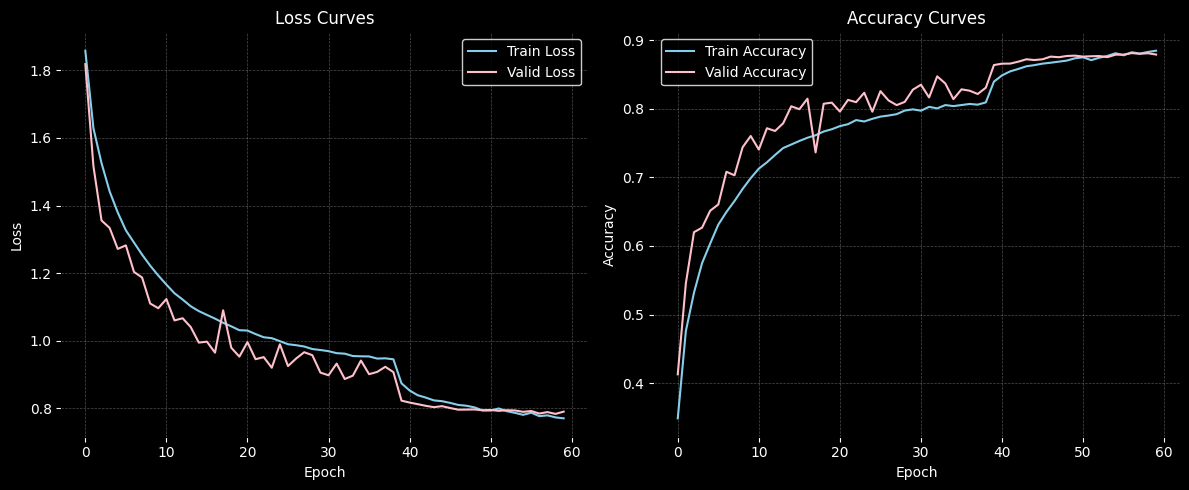

In [20]:
# Plot training and validation loss and accuracy curves for visual performance tracking

# Create side by side subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.patch.set_facecolor("black")

# Loss curve to plot training and validation loss per epoch
ax1.plot(improved_train_losses, label="Train Loss", color="skyblue")
ax1.plot(improved_valid_losses, label="Valid Loss", color="pink")
ax1.set_title("Loss Curves", color="white")
ax1.set_xlabel("Epoch", color="white")
ax1.set_ylabel("Loss", color="white")
ax1.set_facecolor("black")
ax1.tick_params(colors="white")
ax1.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
legend1 = ax1.legend(facecolor='black', edgecolor='white')
for text in legend1.get_texts():
    text.set_color('white')

# Accuracy curve to plot training and validation accuracy per epoch
ax2.plot(improved_train_accuracy, label="Train Accuracy", color="skyblue")
ax2.plot(improved_valid_accuracy, label="Valid Accuracy", color="pink")
ax2.set_title("Accuracy Curves", color="white")
ax2.set_xlabel("Epoch", color="white")
ax2.set_ylabel("Accuracy", color="white")
ax2.set_facecolor("black")
ax2.tick_params(colors="white")
ax2.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
legend2 = ax2.legend(facecolor='black', edgecolor='white')
for text in legend2.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.show()

In [21]:
# Compute and display the accuracy of the model on the test set
improved_test_acc = evaluate_test_set(model, accuracy, test_loader, metric_print=True)

Test Accuracy: 87.73%


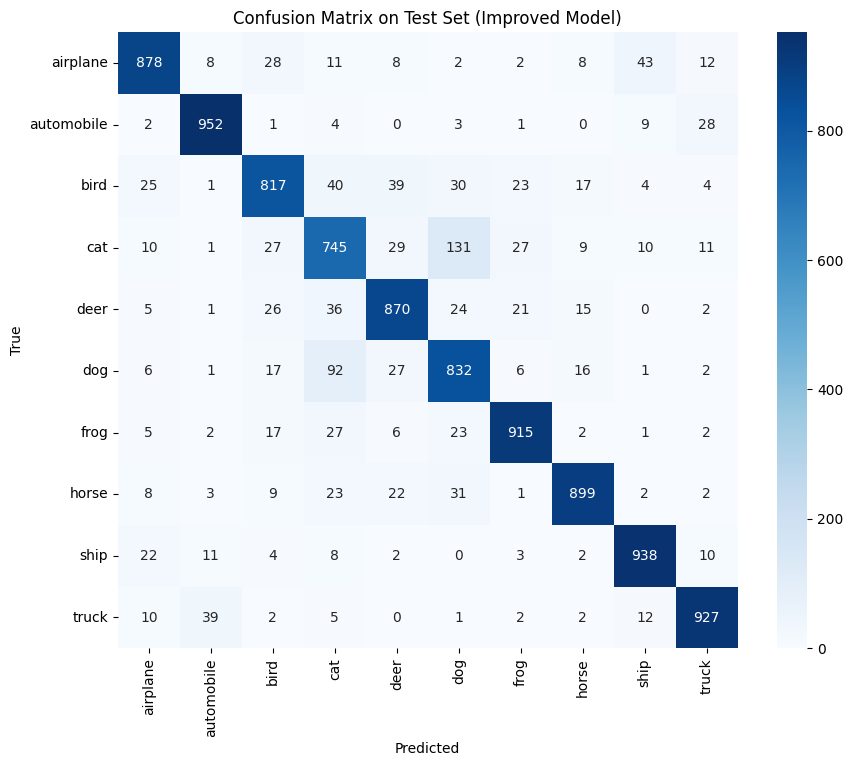

In [22]:
# Create and display a confusion matrix on the test set

model.eval()

# Store predictions and true labels
improved_all_preds = []
improved_all_labels = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch = X_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)

        y_pred_logits = model(X_test_batch)
        y_pred_classes = torch.argmax(y_pred_logits, dim=1)

        improved_all_preds.extend(y_pred_classes.cpu().numpy())
        improved_all_labels.extend(y_test_batch.cpu().numpy())

# Get the confusion matrix
improved_cm = confusion_matrix(improved_all_labels, improved_all_preds)
labels = test_data.classes  

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(improved_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Set (Improved Model)")
plt.show()

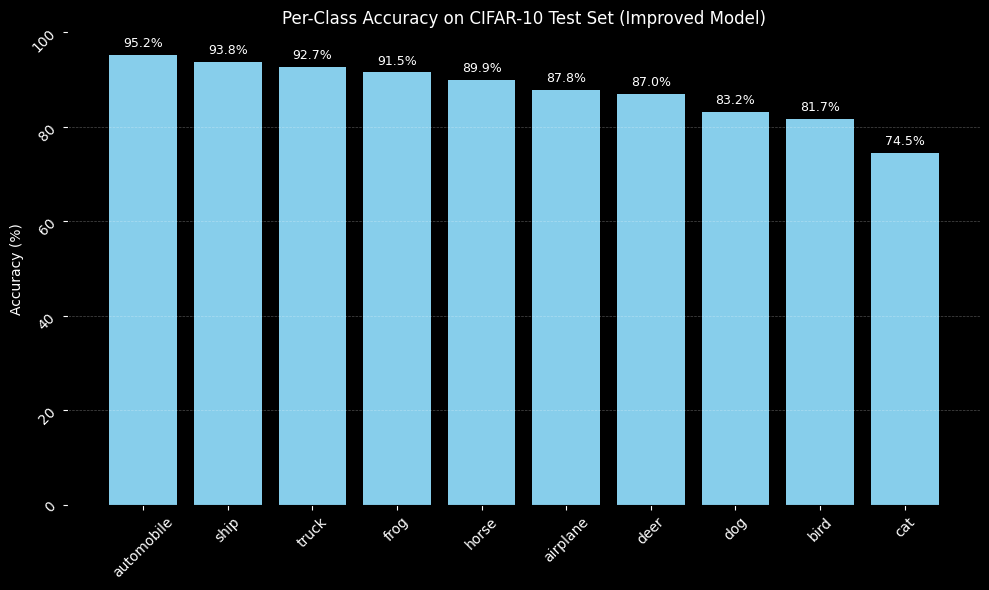

In [23]:
# Create and display a per-class bar chart on test set to evaluate model's performance on each class
improved_all_labels = np.array(improved_all_labels)
improved_all_preds = np.array(improved_all_preds)

class_names = test_data.classes

# Compute per-class accuracy
improved_per_class_acc = []
for i, class_name in enumerate(class_names):
    class_mask = (improved_all_labels == i)
    correct = (improved_all_preds[class_mask] == i).sum()
    total = class_mask.sum()  
    acc = correct / total
    improved_per_class_acc.append(acc)

sorted_indices = np.argsort(improved_per_class_acc)[::-1]
sorted_names = [class_names[i] for i in sorted_indices]
sorted_acc = [improved_per_class_acc[i] for i in sorted_indices]

# Plot bar chart 
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

bars = ax.bar(sorted_names, [a * 100 for a in sorted_acc], color="skyblue")

ax.set_ylabel("Accuracy (%)", color="white")
ax.set_title("Per-Class Accuracy on CIFAR-10 Test Set (Improved Model)", color="white")
ax.set_ylim(0, 100)
ax.tick_params(colors="white", rotation=45)

ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3, axis='y')

for bar, acc in zip(bars, sorted_acc):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
            f"{acc * 100:.1f}%", ha="center", va="bottom", fontsize=9, color="white")

plt.tight_layout()
plt.show()

## LeNet-5 vs Improved Model Comparison Charts
This section presents a comparative evaluation between the baseline LeNet-5 model and the Improved CNN architecture followed by a report. The visualisations include:

- Summary Table of architecture and training differences
- Per-Class Accuracy comparison
- Training and Validation Accuracy curves

These charts highlight how architectural enhancements (deeper layers, batch normalisation, dropout) and training improvements (data augmentation, label smoothing, learning rate scheduling) contribute to significantly better performance on the CIFAR-10 dataset.

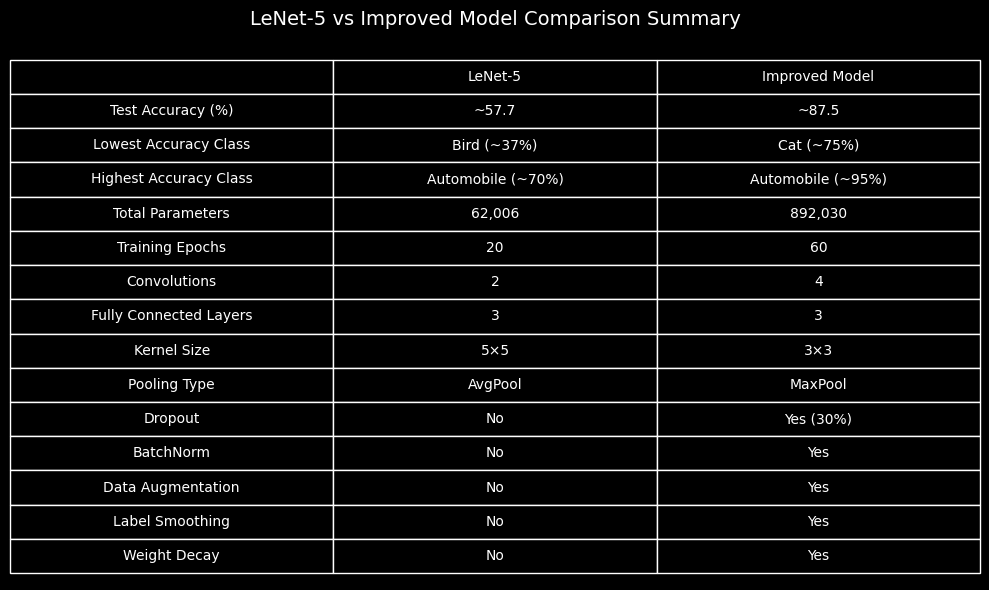

In [24]:
# Create a summary graph to show changes made to the LeNet-5 model and highlight architectural differences and improvements
# Define table data
data = {
    "": [
        "Test Accuracy (%)",
        "Lowest Accuracy Class",
        "Highest Accuracy Class",
        "Total Parameters",
        "Training Epochs",
        "Convolutions",
        "Fully Connected Layers",
        "Kernel Size",
        "Pooling Type",
        "Dropout",
        "BatchNorm",
        "Data Augmentation",
        "Label Smoothing",
        "Weight Decay",
    ],
    "LeNet-5": [
        "~57.7",
        "Bird (~37%)",
        "Automobile (~70%)",
        "62,006",
        "20",
        "2",
        "3",
        "5×5",
        "AvgPool",
        "No",
        "No",
        "No",
        "No",
        "No",
        
    ],
    "Improved Model": [
        "~87.5",
        "Cat (~75%)",
        "Automobile (~95%)",
        "892,030",
        "60",
        "4",
        "3",
        "3×3",
        "MaxPool",
        "Yes (30%)",
        "Yes",
        "Yes",
        "Yes",
        "Yes",
    ]
}

df = pd.DataFrame(data)

# Plot the table
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("black")
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.8)
for key, cell in table.get_celld().items():
    cell.set_text_props(color='white')
    cell.set_edgecolor('white')
    cell.set_facecolor('black')

plt.title("LeNet-5 vs Improved Model Comparison Summary", color="white", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

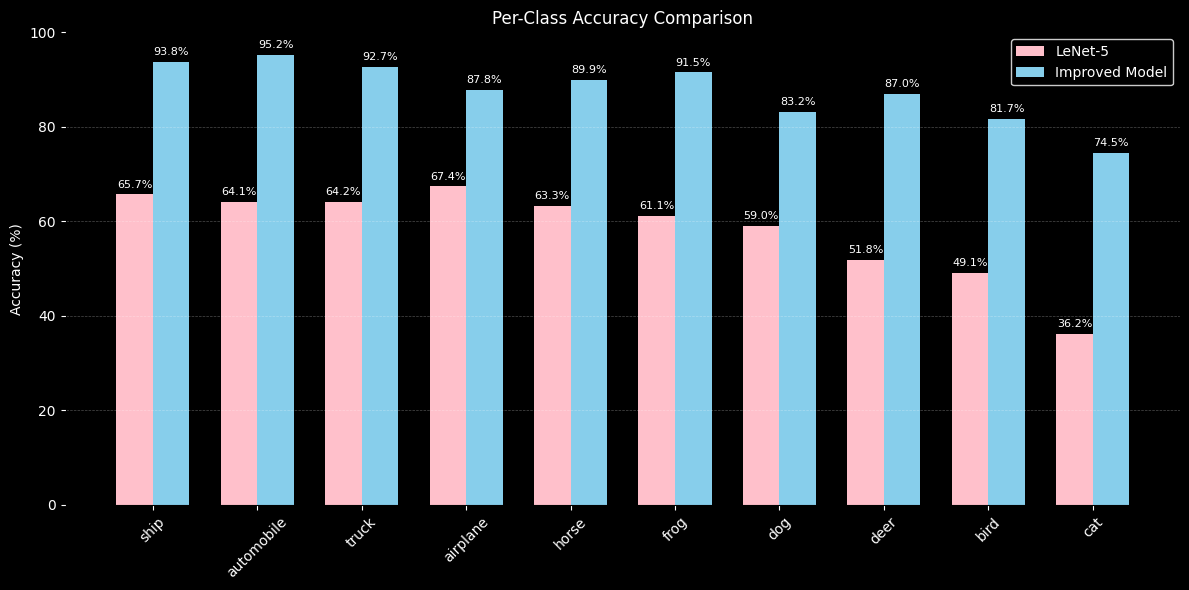

In [25]:
# Create and display a per-class accuracy chart plotting both models to compare perfomance across all classes 

lenet_acc_percent = np.array([a * 100 for a in per_class_acc])
improved_acc_percent = np.array([a * 100 for a in improved_per_class_acc])
class_names = np.array(class_names)

# Compute average of the two models and sort descending
avg_acc = (lenet_acc_percent + improved_acc_percent) / 2
sorted_indices = np.argsort(avg_acc)[::-1]

lenet_acc_percent = lenet_acc_percent[sorted_indices]
improved_acc_percent = improved_acc_percent[sorted_indices]
sorted_class_names = class_names[sorted_indices]

# Plot grouped bar chart
x = np.arange(len(sorted_class_names))  
width = 0.35  

fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

bars1 = ax.bar(x - width/2, lenet_acc_percent, width, label='LeNet-5', color='pink')
bars2 = ax.bar(x + width/2, improved_acc_percent, width, label='Improved Model', color='skyblue')

ax.set_ylabel('Accuracy (%)', color='white')
ax.set_title('Per-Class Accuracy Comparison', color='white')
ax.set_xticks(x)
ax.set_xticklabels(sorted_class_names, rotation=45, color='white')
ax.tick_params(colors="white")
ax.set_ylim(0, 100)
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3, axis='y')

legend = ax.legend(facecolor='black', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', va='bottom', color='white', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', va='bottom', color='white', fontsize=8)

plt.tight_layout()
plt.show()

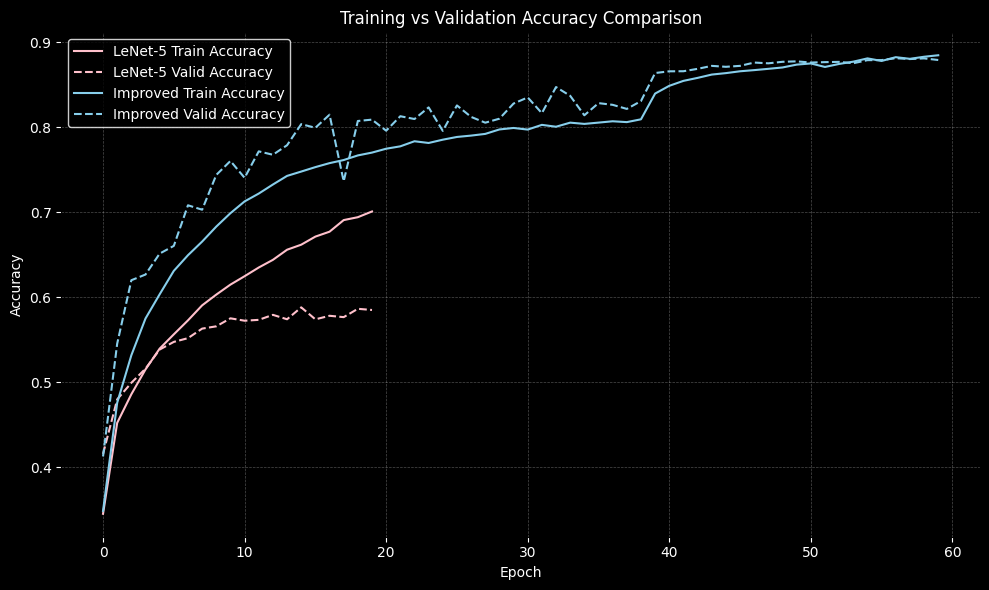

In [26]:
# Plot both LeNet-5 and Improved model training/validation accuracy on the same plot for comparison

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

# Plot LeNet-5 accuracy curves
ax.plot(lenet_train_accuracy, label="LeNet-5 Train Accuracy", color="pink", linestyle='-')
ax.plot(lenet_valid_accuracy, label="LeNet-5 Valid Accuracy", color="pink", linestyle='--')

# Plot Improved model accuracy curves
ax.plot(improved_train_accuracy, label="Improved Train Accuracy", color="skyblue", linestyle='-')
ax.plot(improved_valid_accuracy, label="Improved Valid Accuracy", color="skyblue", linestyle='--')

ax.set_title("Training vs Validation Accuracy Comparison", color="white")
ax.set_xlabel("Epoch", color="white")
ax.set_ylabel("Accuracy", color="white")
ax.tick_params(colors="white")
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)

legend = ax.legend(facecolor='black', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.show()

# Results
Starting from the original LeNet-5 architecture, I made the following step-by-step changes to improve test accuracy and reduce overfitting:

1. **Max Pooling Instead of Average Pooling:**
I replaced average pooling with max pooling to preserve stronger spatial features. This led to a small improvement in validation accuracy (~57.8%).

2. **Dropout for Regularisation:**
My model showed signs of overfitting (training loss improving, validation loss worsening), so I added 30% dropout after the first fully connected layer. This reduced overfitting, as the gap between training and validation loss narrowed, though accuracy remained mostly unchanged.

3. **Data Augmentation:**
To increase training data diversity and improve generalisation, I applied random transformations including cropping, flipping, rotation, and colour jitter. This helped the model learn more robust features, though regularisation slightly reduced early training accuracy.

4. **Smaller Kernels and Deeper Architecture:**
Switching from 5x5 to 3x3 kernels improved accuracy to ~78% by capturing more local patterns. Adding more convolutional layers and feature maps further boosted accuracy (~82%) by enabling richer representations - these made the biggest improvement!

5. **Additional Regularisation and Training Adjustments:**
I added weight decay and label smoothing to improve generalisation. Increasing epochs to 60 allowed more time for convergence, ultimately achieving ~87% test accuracy (~75% by epoch 10).

Overall, the model improved significantly from the classic LeNet-5 (~56% to ~87% accuracy) due to deeper layers, stronger regularisation, and data augmentation. Validation loss was unstable early on due to strong regularisation and data augmentation but eventually stabilised. The confusion matrix and per-class accuracy chart show balanced performance, with highest accuracy on structured objects like automobiles, and lower accuracy on visually similar classes like cats and dogs. These brought accuracy down, so to further improve, I could use advanced augmentation, deeper architecture with attention, or oversampling for difficult classes. With more compute, increasing neuron count or training an ensemble might push test accuracy beyond 90%.